# Boilerplate code for loading data + basic cleaning

In [228]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = Path("data/polygon")

class Dataset:
    def __init__(self, interval: str, symbol: str) -> None:
        self.interval = interval.replace("_15min", "15min")
        self.symbol = symbol
        self.path = DATA_PATH / self.interval / f"{self.symbol}.csv"
        self.df = self.clean_df(pd.read_csv(self.path))
        
    def __str__(self) -> str: return f"Dataset({self.interval}/{self.symbol})"
    def __repr__(self) -> str: return self.__str__()

    @staticmethod
    def clean_df(df):
        df = df.dropna()
        df["returns"] = df["close"].pct_change()
        df["log_returns"] = np.log(df["close"] / df["close"].shift(1))
        return df

    def lineplot(self, col="close") -> None:
        with plt.rc_context({'figure.figsize': (12, 4)}):
            plt.close()
            plt.plot(self.df.dropna()[col], label=self.symbol)
            plt.legend()
            plt.show()

class DatasetGroup:
    def __init__(self, interval: str) -> None: self.interval = interval
    def __getattr__(self, symbol: str) -> Dataset: return Dataset(self.interval, symbol)
class DataMetaclass(type):
    def __getattr__(cls, interval: str) -> DatasetGroup: return DatasetGroup(interval)
class Data(metaclass=DataMetaclass): pass

In [229]:
Data.daily.GLD.df

,datetime,open,high,low,close,volume,returns,log_returns
0,2024-01-02,191.61,192.60,190.50,190.8000,5657589.0,NaN,NaN
1,2024-01-03,190.88,191.22,188.16,189.4000,8170043.0,-0.007338,-0.007365
2,2024-01-04,189.33,190.00,188.69,189.3800,4007864.0,-0.000106,-0.000106
3,2024-01-05,189.56,191.26,187.66,189.4600,7162627.0,0.000422,0.000422
4,2024-01-06,189.46,189.58,189.46,189.4600,507.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
688,2025-11-20,377.52,377.90,371.43,375.0100,10256198.0,-0.006596,-0.006618
689,2025-11-21,375.40,377.23,370.16,374.0500,12058732.0,-0.002560,-0.002563
690,2025-11-22,373.85,374.07,373.85,374.0600,2667.0,0.000027,0.000027
692,2025-11-24,373.94,381.24,371.70,381.0425,9666271.0,0.018667,0.018495


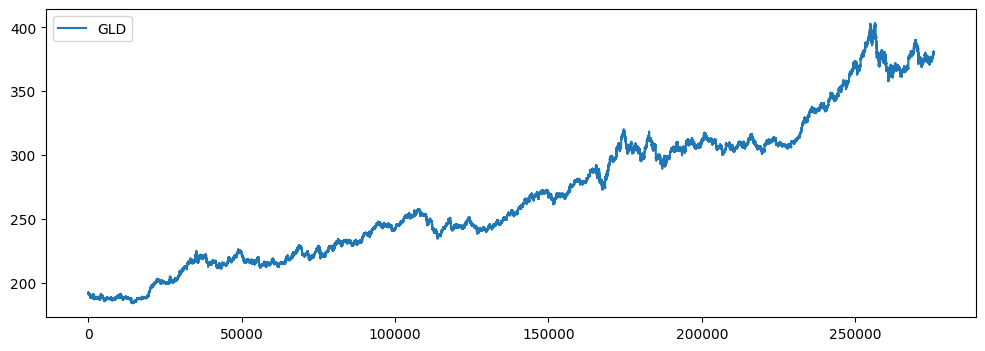

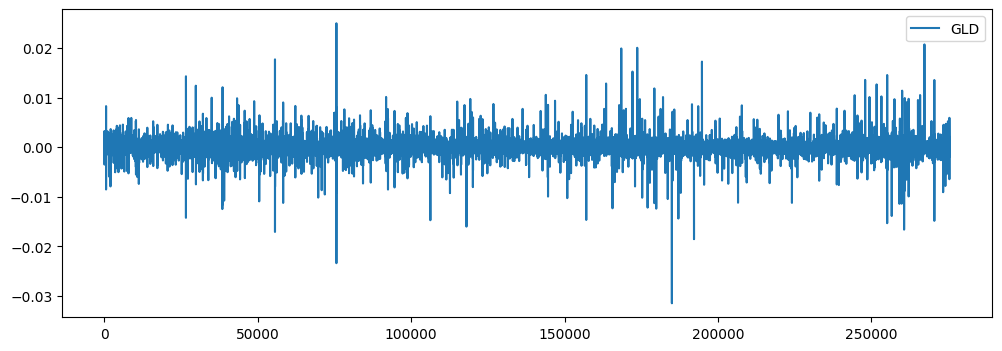

In [230]:
Data.minute.GLD.lineplot()
Data.minute.GLD.lineplot(col="log_returns")

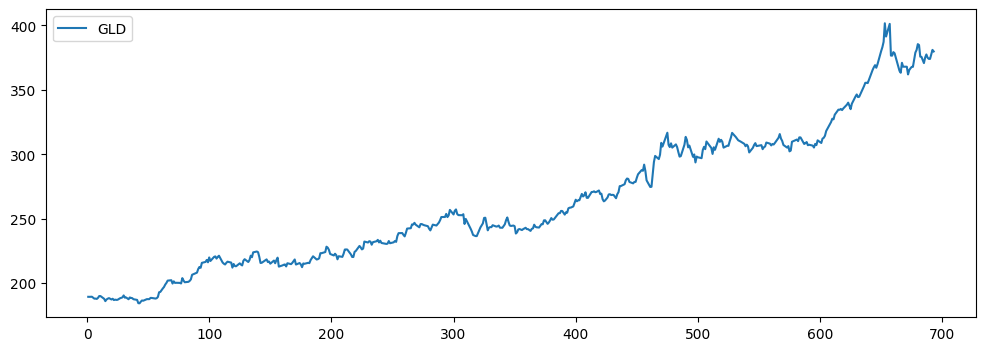

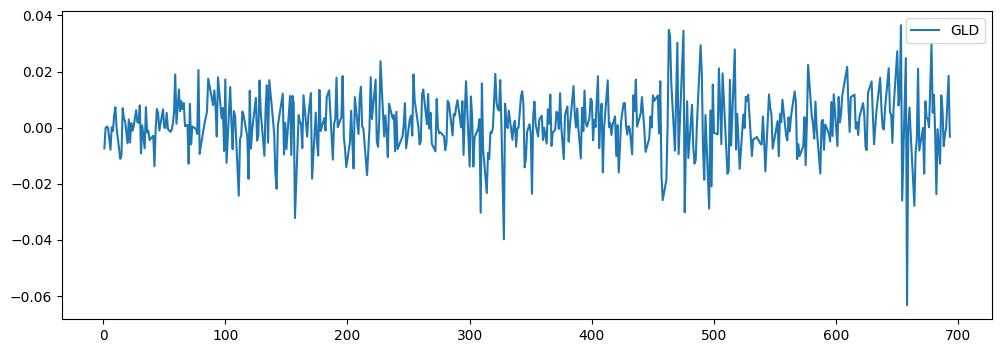

In [231]:
# plotting close prices
Data.daily.GLD.lineplot()
Data.daily.GLD.lineplot(col="log_returns")

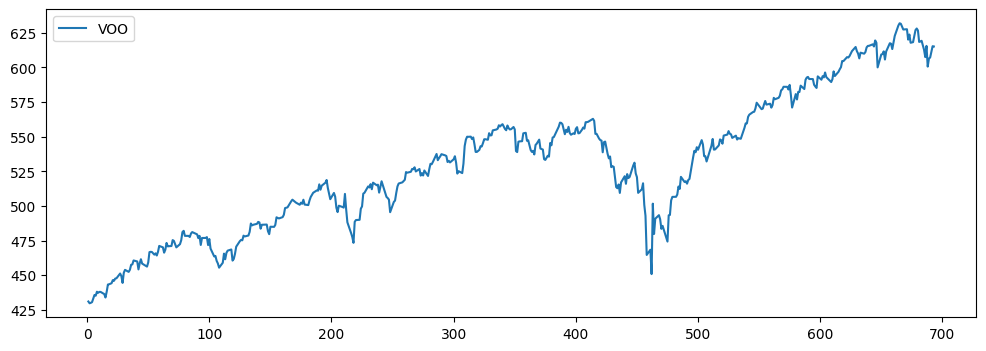

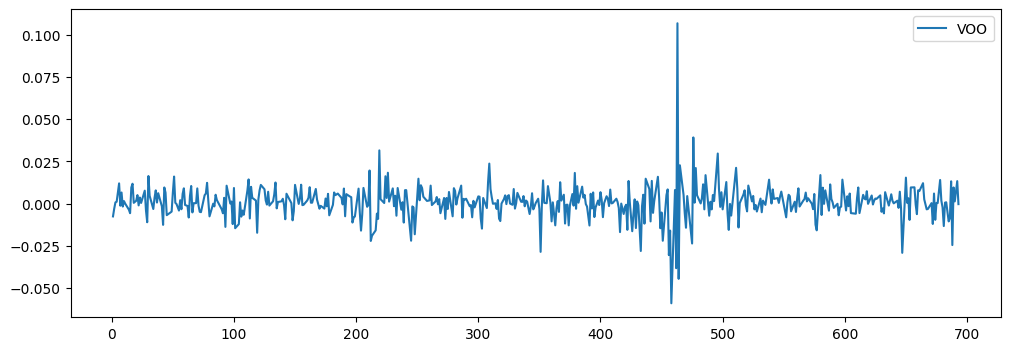

In [232]:
Data.daily.VOO.lineplot()
Data.daily.VOO.lineplot(col="log_returns")

# Clustering of time series data using DBSCAN

In [130]:
Data.daily.VOO.df

,datetime,open,high,low,close,volume,returns,log_returns
0,2024-01-02,437.75,437.7500,432.3600,434.3300,5086551.0,NaN,NaN
1,2024-01-03,434.32,434.3200,430.2500,431.0500,4718310.0,-0.007552,-0.007581
2,2024-01-04,430.89,432.7800,429.2100,429.7700,3811646.0,-0.002969,-0.002974
3,2024-01-05,429.81,432.3000,427.1000,430.1000,5661715.0,0.000768,0.000768
4,2024-01-06,430.58,430.5800,430.5800,430.5800,407.0,0.001116,0.001115
...,...,...,...,...,...,...,...,...
688,2025-11-20,615.48,621.1288,598.4000,600.5700,13853541.0,-0.024249,-0.024548
689,2025-11-21,600.60,611.0100,597.1000,606.3400,9655159.0,0.009608,0.009562
690,2025-11-22,606.39,607.1400,606.2964,607.1400,3108.0,0.001319,0.001319
692,2025-11-24,609.98,616.0900,605.9300,615.2775,6132701.0,0.013403,0.013314


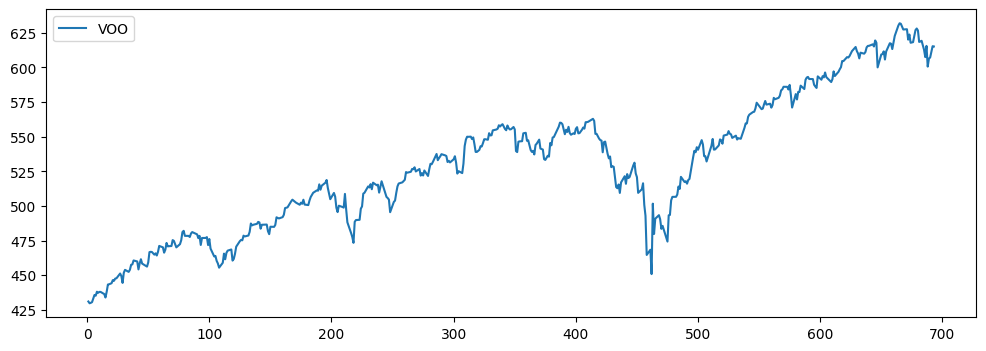

In [233]:
# before clustering
Data.daily.VOO.lineplot()

[ 0  0  0  0  0  0  1  1  0  0  1  0  1  2  1 -1  0  1  2  0  0  0  1  0
  0  1  1  0  0  0  1  1  1 -1 -1 -1  0  1  0  2  0  0  0  1  0  0  0  0
  1  1  1]


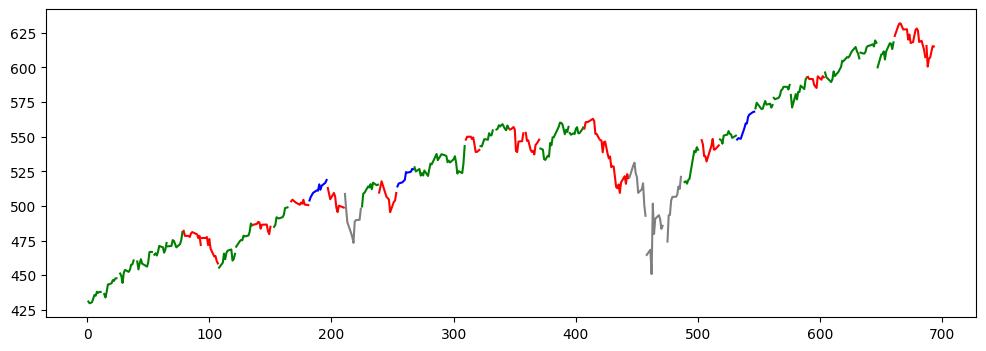

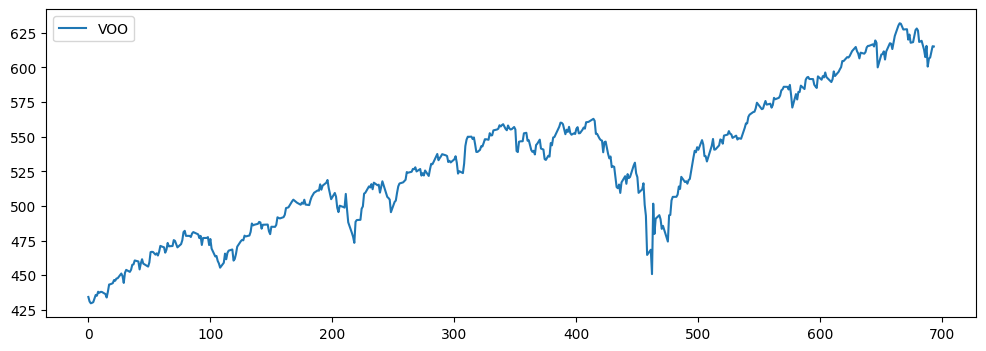

In [207]:
### method 1: cut time series into segment, then cluster segments using DBSCAN
from typing import Sequence

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors

COLORS = ["grey", "green", "red", "blue", "orange", "yellow", "purple", "pink"]

def cluster_segments(
    df: pd.DataFrame,
    num_segments: int = 50
) -> None:
    df = df.dropna()
    segment_size = int( df.shape[0] / num_segments)

    # split df into segments
    segments: list[pd.DataFrame] = [
        df.iloc[i: i+segment_size, :]
        for i in range(0, df.shape[0], segment_size)
    ]

    segment_features: list[list[float]] = []
    for segment in segments:
        rows = segment.to_dict(orient="records")

        direction = rows[0]["close"] < rows[-1]["close"]
        returns_mean = segment["returns"].mean()
        returns_std = segment["returns"].std()
        returns_90_pct = segment["returns"].quantile(0.9)
        returns_10_pct = segment["returns"].quantile(0.1)
        returns_pos_neg_ratio = segment[segment["returns"] > 0].shape[0] / segment[segment["returns"] <= 0].shape[0]
        
        segment_features.append([
            direction,
            returns_mean,
            returns_std,
            returns_90_pct,
            returns_10_pct,
            returns_pos_neg_ratio,
        ])

    feature_df = pd.DataFrame(segment_features)
    feature_df = StandardScaler().fit_transform(feature_df)

    res = DBSCAN(eps=1.5, min_samples=2).fit(feature_df)
    return segments, res.labels_

def plot_segments(segments, labels):
    all_labels = sorted(set(labels))
    label_to_color_map = {label: color for label, color in zip(all_labels, COLORS)}

    with plt.rc_context({'figure.figsize': (12, 4)}):
        plt.close()
        for segment, label in zip(segments, labels):
            plt.plot(segment["close"], color=label_to_color_map[label])
        plt.show()
        

segments, labels = cluster_segments(Data.daily.VOO.df, num_segments=50)
print(labels)
plot_segments(segments, labels)
Data.daily.VOO.lineplot()

[ 0  1  0  1  0  2  0  0  1  0  0  1  1  0  1  0  0  1  0  0  0  0 -1 -1
  0  1  0  0  0  2  0  1  0  0 -1 -1 -1  0  0  1  0  1  0  0  3  0  3 -1
  1  0  0]


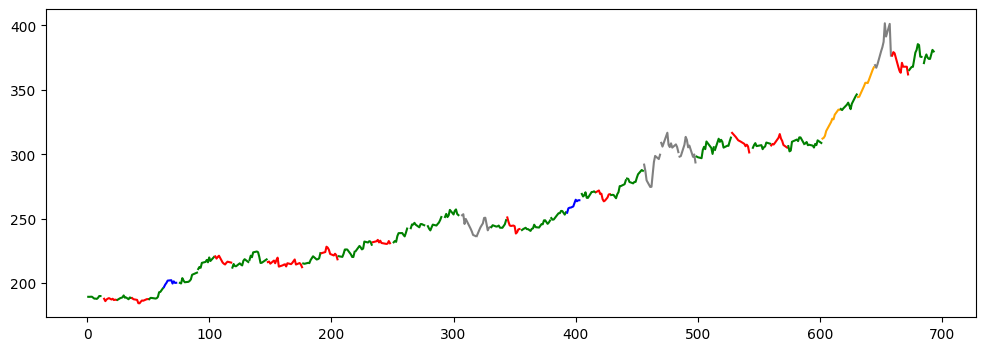

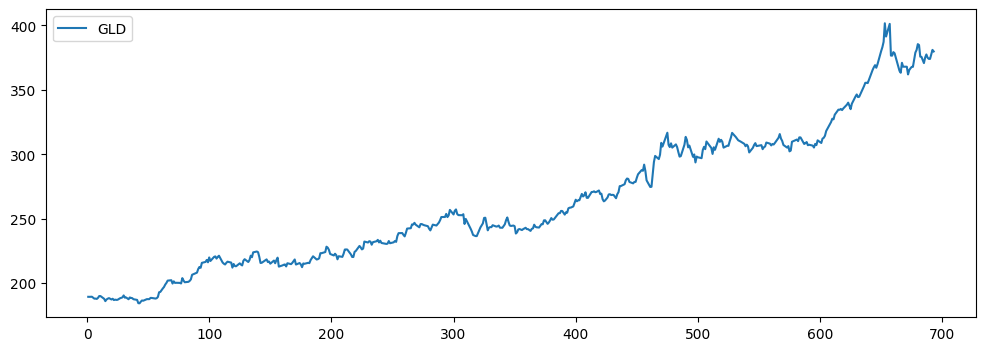

In [234]:
segments, labels = cluster_segments(Data.daily.GLD.df, num_segments=50)
print(labels)
plot_segments(segments, labels)
Data.daily.GLD.lineplot()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 304824875558.5824
Iteration:      2,   Func. Count:     14,   Neg. LLF: 303889264.8818641
Iteration:      3,   Func. Count:     21,   Neg. LLF: 165234140.0770344
Iteration:      4,   Func. Count:     27,   Neg. LLF: 650.9269119108687
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1187.0647556413242
Iteration:      6,   Func. Count:     39,   Neg. LLF: 630.3195921637309
Iteration:      7,   Func. Count:     45,   Neg. LLF: 629.5679474702736
Iteration:      8,   Func. Count:     50,   Neg. LLF: 629.5673885437095
Iteration:      9,   Func. Count:     55,   Neg. LLF: 629.5673736016959
Iteration:     10,   Func. Count:     60,   Neg. LLF: 629.5673719247864
Iteration:     11,   Func. Count:     64,   Neg. LLF: 629.5673719248255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 629.5673719247864
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 1

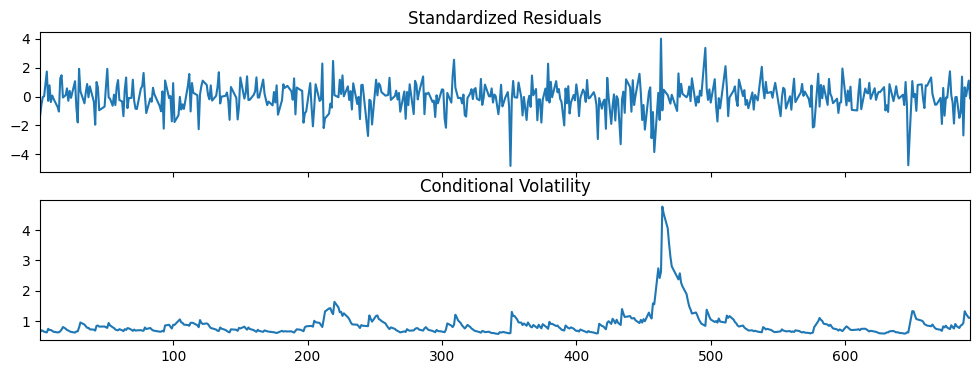

In [223]:
### method 2: using GARCH volatility clustering model

from arch import arch_model

am = arch_model(
    Data.daily.VOO.df["log_returns"].dropna() * 100,
    vol="Garch", 
    p=1, 
    q=1, 
    dist="normal",
)
res = am.fit()

print(res.summary())

with plt.rc_context({'figure.figsize': (12, 4)}):
    res.plot()
    plt.show()